## Final Project: Spoiler detection

### Set up py4j

In [1]:
# Using py4j without pre-determined ports (should be run before running python code)

# Docs: https://www.py4j.org/advanced_topics.html#using-py4j-without-pre-determined-ports-dynamic-port-number
from py4j.java_gateway import (
    JavaGateway, CallbackServerParameters, GatewayParameters,
    launch_gateway)
# Launch Java side with dynamic port and get back the port where server was bound
port = launch_gateway()

# Connect python side to Java side with Java dynamic port, start python callback server with dynamic port
gateway = JavaGateway(
    gateway_parameters=GatewayParameters(port=port),
    callback_server_parameters=CallbackServerParameters(port=0))

# Retrieve port where python callback server was bound to
python_port = gateway.get_callback_server().get_listening_port()

# Tell Java side to connect to the python callback server with the new python port
# Note: We use java_gateway_server attribute that retrieves the GatewayServer instance
gateway.java_gateway_server.resetCallbackClient(
    gateway.java_gateway_server.getCallbackClient().getAddress(),
    python_port)

# Test that callbacks work
from py4j.tests.java_callback_test import IHelloImpl
hello = IHelloImpl()
# example = gateway.jvm.py4j.examples.ExampleClass()
# example.callHello(hello)
hello

### Set up pyspark

In [2]:
import os, pyspark

In [3]:
sc = pyspark.SparkContext()

In [4]:
import re as re
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
import json
import pandas as pd
from pandas.io.json import json_normalize
from tqdm import tqdm
#import regex

In [5]:
# importing some libraries
import pyspark
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
# stuff we'll need for text processing
from nltk.corpus import stopwords
import re as re
from pyspark.ml.feature import HashingTF, IDF
# stuff we'll need for building the model

from pyspark.mllib.linalg import Vector, Vectors
from pyspark.mllib.clustering import LDA, LDAModel
from nltk.stem.wordnet import WordNetLemmatizer

### Read data

In [7]:
df_reviews = sqlContext.read.json("C:/Users/silva/Documents/Text Analytics/IMDB_reviews.json") # ~1GB
df_details = sqlContext.read.json("C:/Users/silva/Documents/Text Analytics/IMDB_movie_details.json") # ~15MB

# If your datasets are in the same folder as this notebook:
# df_reviews = sqlContext.read.json("IMDB_reviews.json") # ~1GB
# df_details = sqlContext.read.json("IMDB_movie_details.json") # ~15MB

In [8]:
type(df_reviews)
type(df_details)

pyspark.sql.dataframe.DataFrame

In [9]:
# df_reviews.head()
df_reviews.count()

573913

In [10]:
df_reviews.printSchema()

root
 |-- is_spoiler: boolean (nullable = true)
 |-- movie_id: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- review_summary: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- user_id: string (nullable = true)



In [11]:
data = df_reviews.select(['movie_id', 'rating', 'is_spoiler', 'review_text'])
data.show(5)

+---------+------+----------+--------------------+
| movie_id|rating|is_spoiler|         review_text|
+---------+------+----------+--------------------+
|tt0111161|    10|      true|In its Oscar year...|
|tt0111161|    10|      true|The Shawshank Red...|
|tt0111161|     8|      true|I believe that th...|
|tt0111161|    10|      true|**Yes, there are ...|
|tt0111161|     8|      true|At the heart of t...|
+---------+------+----------+--------------------+
only showing top 5 rows



### Convert spoiler variable from boolean to string

In [12]:
# Distinct values of is_spoiler col
df_reviews.select("is_spoiler").distinct().show() # All rows are labelled

+----------+
|is_spoiler|
+----------+
|      true|
|     false|
+----------+



In [13]:
# Replace True/False with Spoiler/non-spoiler
from pyspark.sql import functions as f
cols = ["is_spoiler"]

for col in cols:
    df_reviews = data.withColumn(col, 
      f.when(f.col(col) == 'true', 'spoiler')
      .when(f.col(col) == 'false', 'not a spoiler')
      .when(f.col(col).cast("string") == 'spoiler','spoiler' )
      .when(f.col(col).cast("string") == 'not a spoiler', 'not a spoiler'))

In [14]:
# Distinct values of is_spoiler col
df_reviews.select("is_spoiler").distinct().show()

+-------------+
|   is_spoiler|
+-------------+
|not a spoiler|
|      spoiler|
+-------------+



In [15]:
from pyspark.sql.functions import col

df_reviews.groupBy("is_spoiler") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+-------------+------+
|   is_spoiler| count|
+-------------+------+
|not a spoiler|422989|
|      spoiler|150924|
+-------------+------+



### Understand review word counts

In [16]:
# Add a column representing word count of each review
reviews = df_reviews.withColumn('wordCount', f.size(f.split(f.col('review_text'), ' ')))
reviews.show()
reviews.printSchema()

+---------+------+----------+--------------------+---------+
| movie_id|rating|is_spoiler|         review_text|wordCount|
+---------+------+----------+--------------------+---------+
|tt0111161|    10|   spoiler|In its Oscar year...|      843|
|tt0111161|    10|   spoiler|The Shawshank Red...|      223|
|tt0111161|     8|   spoiler|I believe that th...|      250|
|tt0111161|    10|   spoiler|**Yes, there are ...|      766|
|tt0111161|     8|   spoiler|At the heart of t...|      829|
|tt0111161|     8|   spoiler|In recent years t...|      476|
|tt0111161|     9|   spoiler|I have been a fan...|      179|
|tt0111161|    10|   spoiler|I made my account...|      165|
|tt0111161|    10|   spoiler|A friend of mine ...|      250|
|tt0111161|    10|   spoiler|Well I guess I'm ...|      502|
|tt0111161|     8|   spoiler|I finally watched...|      715|
|tt0111161|    10|   spoiler|To tell the truth...|      180|
|tt0111161|     8|   spoiler|From the director...|      510|
|tt0111161|    10|   spo

In [17]:
reviews.orderBy(col("wordCount").desc()) \
    .show()

+---------+------+-------------+--------------------+---------+
| movie_id|rating|   is_spoiler|         review_text|wordCount|
+---------+------+-------------+--------------------+---------+
|tt0266697|     8|not a spoiler|_"If you was a mo...|     2673|
|tt0118583|     8|      spoiler|****The first two...|     2565|
|tt0166924|    10|      spoiler|This is a great p...|     2508|
|tt0316356|    10|      spoiler|Being a coordinat...|     2247|
|tt0166924|    10|      spoiler|There's a sign on...|     2194|
|tt0246460|    10|not a spoiler|"Die Another Day"...|     2175|
|tt0167260|    10|      spoiler|It's over.It's ov...|     2140|
|tt0120755|     1|not a spoiler|IF anyone offers ...|     2118|
|tt0099674|     6|      spoiler|Coppola is very g...|     2073|
|tt0190332|     9|not a spoiler|As of this writin...|     2058|
|tt0266308|     8|      spoiler|Contains Spoilers...|     2042|
|tt0290673|    10|      spoiler|Argentinian born ...|     1991|
|tt0110148|    10|      spoiler|I can't 

In [18]:
# !pip install handyspark

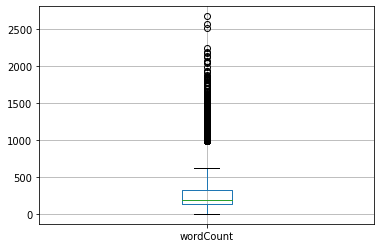

In [19]:
# Build a boxplot to understand distribution of word counts
from handyspark import *
reviews_hdf = reviews.toHandy()

reviews_hdf.cols['wordCount'].boxplot()

In [20]:
# Look at basic statistics
reviews.describe('wordCount').show()

# reviews_hdf.cols['wordCount'].min() # 1
# reviews_hdf.cols['wordCount'].max() # 2673
# reviews_hdf.cols['wordCount'].median() # 191
# reviews_hdf.cols['wordCount'].q1() # 133
# reviews_hdf.cols['wordCount'].q3() # 329
# reviews_hdf.cols['wordCount'].stddev() # 195.438284
# reviews_hdf.cols['wordCount'].mode() # 129

+-------+------------------+
|summary|         wordCount|
+-------+------------------+
|  count|            573913|
|   mean| 259.3990517726554|
| stddev|195.43828380845403|
|    min|                 1|
|    max|              2673|
+-------+------------------+



In [21]:
# Detect outliers
reviews_hdf.outliers(method='tukey', k=3.)
hdf_fenced = reviews_hdf.fence(['wordCount']) # fence the outliers
hdf_fenced.fences_ # what are the fences? --> {'wordCount': [-161.0, 623.0]}

# Limit to reviews with word counts 0 - 623 words


{'wordCount': [-161.0, 623.0]}

In [22]:
# OG number of reviews
reviews.count()

573913

In [23]:
# Filter for reviews where word count is between 0 and 623
filtered_reviews = reviews.filter("wordCount <= '623'")
filtered_reviews.count()

534764

### Balance the dataset 
Adjust to 50/50 spoiler/non-spoiler reviews

In [24]:
# Understand how imbalanced the dataset is
from pyspark.sql.functions import col

filtered_reviews.groupBy("is_spoiler") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+-------------+------+
|   is_spoiler| count|
+-------------+------+
|not a spoiler|402326|
|      spoiler|132438|
+-------------+------+



In [25]:
# Create two dfs for sampling purposes
spoilerDf = filtered_reviews.filter("is_spoiler == 'spoiler'")
nonspoilerDf = filtered_reviews.filter("is_spoiler == 'not a spoiler'")

In [26]:
sampleRatio = 132438/402326
nonspoilerSampleDf = nonspoilerDf.sample(sampleRatio)

In [27]:
filtered_reviews = spoilerDf.unionAll(nonspoilerSampleDf)

filtered_reviews.groupBy("is_spoiler") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+-------------+------+
|   is_spoiler| count|
+-------------+------+
|      spoiler|132438|
|not a spoiler|132255|
+-------------+------+



In [28]:
filtered_reviews.printSchema()

root
 |-- movie_id: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- is_spoiler: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- wordCount: integer (nullable = false)



In [29]:
# Remove col "wordCount" from df
new_reviews = filtered_reviews.select(['movie_id', 'rating', 'is_spoiler', 'review_text'])
new_reviews.show(5)

+---------+------+----------+--------------------+
| movie_id|rating|is_spoiler|         review_text|
+---------+------+----------+--------------------+
|tt0111161|    10|   spoiler|The Shawshank Red...|
|tt0111161|     8|   spoiler|I believe that th...|
|tt0111161|     8|   spoiler|In recent years t...|
|tt0111161|     9|   spoiler|I have been a fan...|
|tt0111161|    10|   spoiler|I made my account...|
+---------+------+----------+--------------------+
only showing top 5 rows



### Tokenisation, stem & lemmatisation, removal of stop words

In [30]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer

# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="review_text", outputCol="words", pattern="\\W")
# stop words
add_stopwords = ["http","https","amp","rt","t","c","the"] 
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)
# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

In [31]:
descriptions = new_reviews.rdd.map(lambda x : x['review_text']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
lmtzr = WordNetLemmatizer()

In [32]:
# Note: Long run-time ~10mins
tokens = descriptions.map( lambda document: document.strip().lower())               \
    .map( lambda document: re.split(" ", document))          \
    .map( lambda word: [x for x in word if x.isalpha()])           \
    .map( lambda word: [x for x in word if len(x) > 3] )           \
    .map( lambda word: [x for x in word if x not in StopWords])    \
    .map( lambda word: [lmtzr.lemmatize(x,'v') for x in word]) \
    .zipWithIndex()

In [33]:
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])
df_txts.show()

+--------------------+-----+
|       list_of_words|index|
+--------------------+-----+
|[shawshank, redem...|    0|
|[believe, film, b...|    1|
|[recent, years, i...|    2|
|[movie, long, see...|    3|
|[make, account, i...|    4|
|[friend, mine, li...|    5|
|[well, guess, lit...|    6|
|[tell, young, mov...|    7|
|[director, come, ...|    8|
|[film, baby, film...|    9|
|[go, deep, explan...|   10|
|[never, film, sil...|   11|
|[always, define, ...|   12|
|[enjoy, read, goo...|   13|
|[best, movies, ev...|   14|
|[deliberately, mi...|   15|
|[bug, movie, rat,...|   16|
|[shawshank, shaws...|   17|
|[good, surely, ri...|   18|
|[shawshank, redem...|   19|
+--------------------+-----+
only showing top 20 rows



### TF-IDF to understand word/token importance

In [36]:
# TF
# Note: Long run-time ~10mins
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=10.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)

In [37]:
# IDF
# Note: Long run-time ~10mins
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [38]:
result_tfidf.show()

+--------------------+-----+--------------------+--------------------+
|       list_of_words|index|        raw_features|            features|
+--------------------+-----+--------------------+--------------------+
|[shawshank, redem...|    0|(5000,[0,10,11,19...|(5000,[0,10,11,19...|
|[believe, film, b...|    1|(5000,[1,2,3,6,10...|(5000,[1,2,3,6,10...|
|[recent, years, i...|    2|(5000,[0,1,2,3,4,...|(5000,[0,1,2,3,4,...|
|[movie, long, see...|    3|(5000,[0,1,2,3,5,...|(5000,[0,1,2,3,5,...|
|[make, account, i...|    4|(5000,[0,3,8,10,1...|(5000,[0,3,8,10,1...|
|[friend, mine, li...|    5|(5000,[0,2,4,6,12...|(5000,[0,2,4,6,12...|
|[well, guess, lit...|    6|(5000,[1,2,5,7,8,...|(5000,[1,2,5,7,8,...|
|[tell, young, mov...|    7|(5000,[0,1,25,28,...|(5000,[0,1,25,28,...|
|[director, come, ...|    8|(5000,[1,3,4,5,7,...|(5000,[1,3,4,5,7,...|
|[film, baby, film...|    9|(5000,[1,2,3,5,7,...|(5000,[1,2,3,5,7,...|
|[go, deep, explan...|   10|(5000,[0,1,3,7,8,...|(5000,[0,1,3,7,8,...|
|[neve

### Spark pipeline - basic

In [34]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
label_stringIdx = StringIndexer(inputCol = "is_spoiler", outputCol = "label")
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])

# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(new_reviews)
dataset = pipelineFit.transform(new_reviews)
dataset.show(5)

+---------+------+----------+--------------------+--------------------+--------------------+--------------------+-----+
| movie_id|rating|is_spoiler|         review_text|               words|            filtered|            features|label|
+---------+------+----------+--------------------+--------------------+--------------------+--------------------+-----+
|tt0111161|    10|   spoiler|The Shawshank Red...|[the, shawshank, ...|[shawshank, redem...|(10000,[0,1,2,3,4...|  0.0|
|tt0111161|     8|   spoiler|I believe that th...|[i, believe, that...|[i, believe, that...|(10000,[0,1,2,3,4...|  0.0|
|tt0111161|     8|   spoiler|In recent years t...|[in, recent, year...|[in, recent, year...|(10000,[0,1,2,3,4...|  0.0|
|tt0111161|     9|   spoiler|I have been a fan...|[i, have, been, a...|[i, have, been, a...|(10000,[0,1,2,3,4...|  0.0|
|tt0111161|    10|   spoiler|I made my account...|[i, made, my, acc...|[i, made, my, acc...|(10000,[0,1,2,3,6...|  0.0|
+---------+------+----------+-----------

## Part 1) Spoiler Detection Modeling
Experiment with various classification models to build a good model for predicting whether a movie review has spoiler content. This model will be used to inform subsequent parts of the project.

### Split Data to Train vs. Test

In [35]:
# Partitioning data into test and training sets (set seed for reproducibility)
# Note: Long run-time ~10mins
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 185504
Test Dataset Count: 79189


### Logistic Regression - basic model

In [36]:
#logistic regression
# Note: Long run-time ~10mins
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("review_text","is_spoiler","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+----------+------------------------------+-----+----------+
|                   review_text|is_spoiler|                   probability|label|prediction|
+------------------------------+----------+------------------------------+-----+----------+
|When the monster first appe...|   spoiler|[0.9998526859575743,1.47314...|  0.0|       0.0|
|****This is the spoiler****...|   spoiler|[0.9997395867727934,2.60413...|  0.0|       0.0|
|THIS DEFINITELY HAS SPOILER...|   spoiler|[0.9990549991514793,9.45000...|  0.0|       0.0|
|This brilliant film directe...|   spoiler|[0.9989338140900832,0.00106...|  0.0|       0.0|
|Ok. Not many films impress ...|   spoiler|[0.9977154976188852,0.00228...|  0.0|       0.0|
|This film (spoiler alert) i...|   spoiler|[0.9975348528315906,0.00246...|  0.0|       0.0|
|SPOILER ALERT!!!Iron Man 3 ...|   spoiler|[0.9974469806604119,0.00255...|  0.0|       0.0|
|The bit with the kid is pro...|   spoiler|[0.9973630682571987,0.00263...|  0.0|

In [37]:
#function for precision/recall
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def evaluate(predictions):
    log = {}

    # Show Validation Score (AUROC)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
    log['AUROC'] = "%f" % evaluator.evaluate(predictions)    
    print("Area under ROC = {}".format(log['AUROC']))

    # Show Validation Score (AUPR)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
    log['AUPR'] = "%f" % evaluator.evaluate(predictions)
    print("Area under PR = {}".format(log['AUPR']))

    return log

In [38]:
# Note: Long run-time ~10mins
log = evaluate(predictions)

Area under ROC = 0.757863
Area under PR = 0.738353


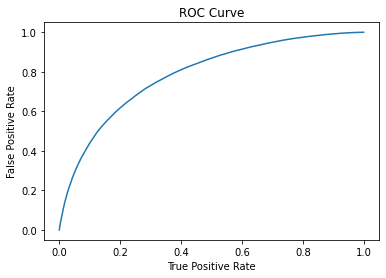

In [39]:
# Extract the summary from the returned LogisticRegressionModel instance trained
import matplotlib.pyplot as plt
trainingSummary = lrModel.summary

#trainingSummary.roc.show(n=10, truncate=15)
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

precision/recall: DataFrame[recall: double, precision: double]


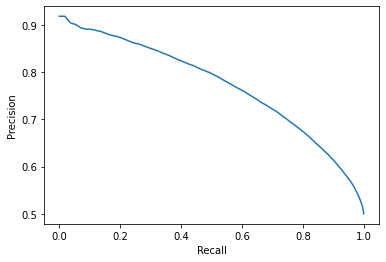

In [40]:
#View the precision and recall
print("precision/recall: " + str(trainingSummary.pr))
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

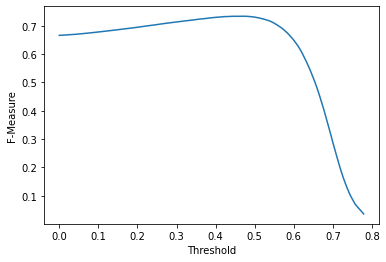

In [41]:
# Set the model threshold to maximize F-Measure
#trainingSummary.fMeasureByThreshold.show(n=10, truncate = 15)
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

In [42]:
# Accuracy
# Note: Long run-time ~10mins
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)
#accuracy: 0.6829943437710129

0.6860485675894255

In [43]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
print("Training: Area Under ROC: " + str(trainingSummary.areaUnderROC))

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Training: Area Under ROC: 0.7864540211173237
Test: Area Under ROC: 0.7578628212740164


### Logistic Regression with TF-IDF features

In [44]:
# Note: Long run-time ~10mins
from pyspark.ml.feature import HashingTF, IDF

hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf2 = IDF(inputCol="rawFeatures", outputCol="features")
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf2, label_stringIdx])
pipelineFit = pipeline.fit(new_reviews)
dataset = pipelineFit.transform(new_reviews)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("review_text","is_spoiler","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+----------+------------------------------+-----+----------+
|                   review_text|is_spoiler|                   probability|label|prediction|
+------------------------------+----------+------------------------------+-----+----------+
|When the monster first appe...|   spoiler|[0.999307122222365,6.928777...|  0.0|       0.0|
|****This is the spoiler****...|   spoiler|[0.9987491671859607,0.00125...|  0.0|       0.0|
|This brilliant film directe...|   spoiler|[0.9982979611207095,0.00170...|  0.0|       0.0|
|So Wolverine saved this one...|   spoiler|[0.9982007071983332,0.00179...|  0.0|       0.0|
|The bit with the kid is pro...|   spoiler|[0.9978419090485574,0.00215...|  0.0|       0.0|
|One of the worst Star Trek ...|   spoiler|[0.9972325968578232,0.00276...|  0.0|       0.0|
|You know those cretinous B-...|   spoiler|[0.9971577179372182,0.00284...|  0.0|       0.0|
|I joined IMDb simply to rev...|   spoiler|[0.996476869308338,0.003523...|  0.0|

In [45]:
# Area under ROC, area under PR
# Note: Long run-time ~10mins
log = evaluate(predictions)

Area under ROC = 0.747583
Area under PR = 0.729482


In [46]:
# Accuracy
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)
#accuracy: 0.6757144617753544

0.6775548360816912

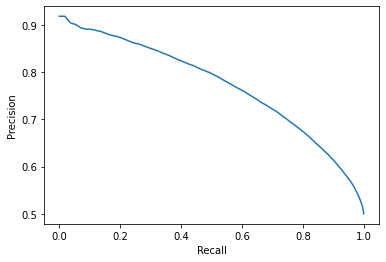

In [47]:
#View the precision and recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

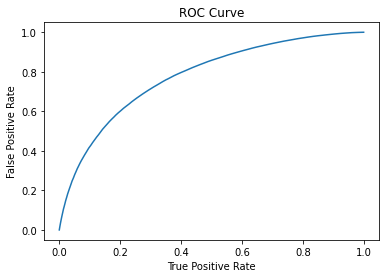

In [48]:
trainingSummary = lrModel.summary

#trainingSummary.roc.show(n=10, truncate=15)
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [49]:
# Run Results on Training Data
trainingSummary = lrModel.summary
print("Training: Area Under ROC: " + str(trainingSummary.areaUnderROC))

# Predict on Test Data
predictions = lrModel.transform(testData)
# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
#Training ROC: 77.7%
#Test ROC: 74.3% 

Training: Area Under ROC: 0.7765116227722441
Test: Area Under ROC: 0.7475834933566737


### Logistic Regression with Word2Vec features

In [50]:
from pyspark.ml.feature import Word2Vec

# Learn a mapping from words to Vectors.
word2Vec = Word2Vec(vectorSize=10, minCount=5, inputCol="filtered", outputCol="features") # vectorSize=1000 # hm

# Redo Pipeline
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, word2Vec, label_stringIdx])

In [51]:
# Note: Long run-time ~30mins
# Fit pipeline to training docs
pipelineFit = pipeline.fit(new_reviews)
dataset = pipelineFit.transform(new_reviews)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

# Build model
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0, family = "binomial")

# Train model with train data
lrModel = lr.fit(trainingData)

In [52]:
# Predict on test data
predictions = lrModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("review_text","is_spoiler","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-------------+------------------------------+-----+----------+
|                   review_text|   is_spoiler|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|In 2014, Peter Quill, Gamor...|not a spoiler|[0.851511260341418,0.148488...|  1.0|       0.0|
|A retired couple, Shūkichi ...|      spoiler|[0.8466164678957426,0.15338...|  0.0|       0.0|
|In a fairy tale, Princess M...|      spoiler|[0.8298711387261245,0.17012...|  0.0|       0.0|
|Ferdinand is a young bull w...|not a spoiler|[0.8295636056505544,0.17043...|  1.0|       0.0|
|In 1988, a businessman name...|      spoiler|[0.8286983605090351,0.17130...|  0.0|       0.0|
|Teenager Marty McFly is an ...|      spoiler|[0.8273321163856948,0.17266...|  0.0|       0.0|
|Carl Fredricksen is a young...|      spoiler|[0.825940163538746,0.174059...|  0.0|       0.0|
|In 1944 the fascist Captain...|      spoiler|[0.8

In [53]:
# Area under ROC, area under PR
# Note: Long run-time ~10mins
log = evaluate(predictions)

Area under ROC = 0.673896
Area under PR = 0.669295


In [54]:
# Accuracy
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)
#accuracy: 

0.6267876614329393

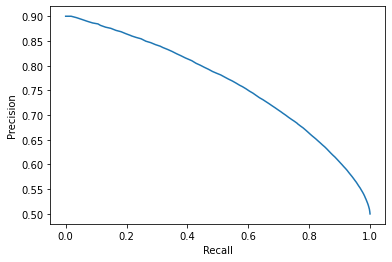

In [55]:
# Precision and recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

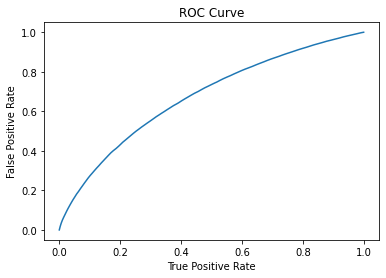

In [56]:
# Area under ROC
trainingSummary = lrModel.summary

#trainingSummary.roc.show(n=10, truncate=15)
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [57]:
# Run Results on Training Data
trainingSummary = lrModel.summary
print("Training: Area Under ROC: " + str(trainingSummary.areaUnderROC))

# Predict on Test Data
predictions = lrModel.transform(testData)
# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
#Training ROC: 0.7151461681686627
#Test ROC: 

Training: Area Under ROC: 0.6731965616202823
Test: Area Under ROC: 0.673896427065311


### Random Forest model

In [58]:
#randomforest model
# Note: Long run-time ~10mins

from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees = 10)

# Train model with Training Data
rfModel = rf.fit(trainingData)
predictions = rfModel.transform(testData)
predictions.filter(predictions['prediction'] == 0) \
    .select("review_text","is_spoiler","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+----------+------------------------------+-----+----------+
|                   review_text|is_spoiler|                   probability|label|prediction|
+------------------------------+----------+------------------------------+-----+----------+
|One woman took on a corpora...|   spoiler|[0.6775049714434234,0.32249...|  0.0|       0.0|
|My 7-year-old daughter aske...|   spoiler|[0.6775049714434234,0.32249...|  0.0|       0.0|
|Hannibal Lechter.There has ...|   spoiler|[0.6775049714434234,0.32249...|  0.0|       0.0|
|There is an interesting mom...|   spoiler|[0.6775049714434234,0.32249...|  0.0|       0.0|
|This film is a wonderful re...|   spoiler|[0.6775049714434234,0.32249...|  0.0|       0.0|
|The movie "The Accountant" ...|   spoiler|[0.6775049714434234,0.32249...|  0.0|       0.0|
|I had only heard about Lion...|   spoiler|[0.6775049714434234,0.32249...|  0.0|       0.0|
|This movie is full of styli...|   spoiler|[0.6775049714434234,0.32249...|  0.0|

In [59]:
# RF accuracy
# Note: Long run-time ~10mins
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)
# numTrees: 10, accuracy: 0.6167863701070468

0.6297238841587549

In [60]:
# Area under curve evaluation
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = predictions.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is: ", metrics.areaUnderROC)

The ROC score is:  0.671587151002042


In [61]:
# Precision and recall
log = evaluate(predictions)

Area under ROC = 0.671587
Area under PR = 0.658796


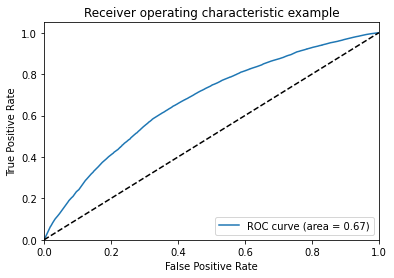

In [62]:
# Plot the ROC curve
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Gradient-boosted tree classifier

In [63]:
# Note: Long run-time >1hour
from pyspark.ml.classification import GBTClassifier

# Train a gbt model
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
gbtModel = gbt.fit(trainingData)
predictions = gbtModel.transform(testData)

# See some sample rows
predictions.select("prediction", "label", "features").show(5)


# predictions.filter(predictions['prediction'] == 0) \
#     .select("review_text","is_spoiler","probability","label","prediction") \
#     .orderBy("probability", ascending=False) \
#     .show(n = 10, truncate = 30)

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|[0.00612635563689...|
|       0.0|  0.0|[-0.0671021963209...|
|       0.0|  0.0|[-0.1137438188903...|
|       0.0|  0.0|[-0.0120790492160...|
|       1.0|  0.0|[0.03210926906290...|
+----------+-----+--------------------+
only showing top 5 rows



In [64]:
# Gbt accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator.evaluate(predictions)

# print("Test Error = %g" % (1.0 - accuracy))
# gbtModelStages = gbtModel.stages[2]
# print(gbtModel)  # summary only

# maxIter: 10, accuracy: 0.6373391642862559

0.6362878682645317

In [65]:
# Area under curve evaluation
results = predictions.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is: ", metrics.areaUnderROC)

The ROC score is:  0.6855260538358802


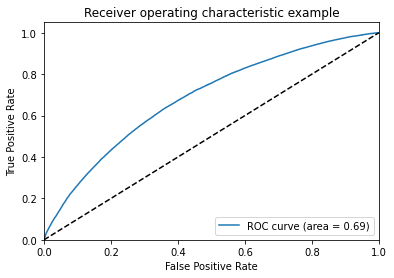

In [66]:
# Plot the ROC curve
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [68]:
# Precision and recall
log = evaluate(predictions)

Area under ROC = 0.685526
Area under PR = 0.675357


In [70]:
# type(predictions)
# predictions.count() # testData count is 160424
predictions.printSchema()
predictions.show(5)

root
 |-- movie_id: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- is_spoiler: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

+---------+------+----------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
| movie_id|rating|is_spoiler|         review_text|               words|            filtered|            features|label|       rawPrediction|         probability|prediction|
+---------+------+----------+--------------------+--------------------+--------------------+-------------

## Part 2) Movie Review Summarisation
Given user input on a movie title/ID, filter for movie reviews without spoilers and return a summary doc consisting of overall rating, mean user rating and a text summarisation (extractive summary) of the reviews. 

Example movie ID: tt0111161

In [78]:
predictions_df = predictions

In [76]:
predictions_df.show(2)

+---------+------+-------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
| movie_id|rating|   is_spoiler|         review_text|               words|            filtered|            features|label|       rawPrediction|         probability|prediction|
+---------+------+-------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|tt0012349|    10|not a spoiler|A classic. One of...|[a, classic, one,...|[a, classic, one,...|[0.01216656929822...|  0.0|[1.02127237435592...|[0.88519213678496...|       0.0|
|tt0012349|    10|not a spoiler|Charlie Chaplin, ...|[charlie, chaplin...|[charlie, chaplin...|[-0.0118891456954...|  0.0|[0.05154157976661...|[0.52574799377612...|       0.0|
+---------+------+-------------+--------------------+--------------------+--------------------+--------------------+----

In [74]:
# !pip install sumy

In [79]:
# LexRank for extractive summarisation
from sumy.parsers.plaintext import PlaintextParser
from sumy.parsers.html import HtmlParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

class TextSummary(object):

    def __init__(self, feeds_str, num_sents):
        self.summary = str()
        
        parser = PlaintextParser.from_string(feeds_str, Tokenizer("english"))
        summarizer = LexRankSummarizer()

        sentences = summarizer(parser.document, num_sents) # Summarize the document with x number of sentences
        for sentence in sentences:
            self.summary += (sentence.__unicode__())

    def output(self):
        return self.summary

### The "!Spoilers Here" Tool

In [82]:
from pyspark.sql.functions import col, avg
print('Hey! Please enter a movie ID. e.g. tt0111161')
chosen_movie_id = input()

matching_movie_reviews = predictions_df.filter(predictions_df.movie_id == chosen_movie_id)
chosen_movie_reviews = matching_movie_reviews.filter(matching_movie_reviews.is_spoiler == 'not a spoiler')

chosen_movie_reviews_combined = chosen_movie_reviews.select('review_text').collect() # list
chosen_movie_reviews_combined = ' '.join(chosen_movie_reviews_combined[0])

# Extractive text summarisation of matching reviews
chosen_movie_summary = TextSummary(chosen_movie_reviews_combined, 3) # Extractive summary into 3 sentences
print("Spoiler-free review summary: \n" + chosen_movie_summary.output())

# Overall movie rating
chosen_movie_overall_rating = df_details.filter(df_details.movie_id == chosen_movie_id)
chosen_movie_overall_rating = chosen_movie_overall_rating.select(['rating'])
chosen_movie_overall_rating = ' '.join(chosen_movie_overall_rating.collect()[0])
print("Overall movie rating: " + chosen_movie_overall_rating)

# Average user rating (user review-based)
average_user_rating = chosen_movie_reviews.agg(avg(col("rating")))
average_user_rating = (average_user_rating.collect()[0])["avg(rating)"]
average_user_rating = str(average_user_rating)
print("Mean user rating: " + average_user_rating)

Hey! Please enter a movie ID. e.g. tt0111161
tt0143145
Spoiler-free review summary: 
After the mediocre GOLDENEYE and the great TOMORROW NEVER DIES, Pierce Brosnan is back for the third time in the character of James Bond.Don't try to make american films, you lost your chance in LOST AND FOUND, now it's worst than ever.We are far away from MANON DES SOURCES ...  Robert Carlyle rocks in TRAINSPOTING, funny in THE FULL MONTY, in THE WORLD IS NOT ENOUGH, he prooves to everybody that he's not good playing the bad man.
Overall movie rating: 6.4
Mean user rating: 6.720338983050848


### All done